# Steps to follow:
1. train your model
2. obtain train embeddings (requires train_subset.csv, 3000 samples balanced=>1500pneum, 1500no pneum)
3. compute PD (requires test.csv, 1000 samples balanced=>500pneum, 500no pneum)
4. Plot/analyse/visualize PD

# Import Libraries

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt  
from tqdm import tqdm   
import pandas as pd
import numpy as np
import os, sys, pdb
import torch, torchvision
import pickle
import time
from PIL import Image
from brokenaxes import brokenaxes
# from pykeops.torch import LazyTensor

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

sys.path.insert(0,'/xxx/home/xxx/xxx22p/xxx/projects/augmentation_by_explanation_eccv22/Classifier')
import models, datasets
sys.path.insert(0,'/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/scripts')
from utils import *

# Step-2: Obtain Train Embeddings
it is assumed that:
* you already have a trained model
* you have your training subset data file (e.g., 1500 diseased patients, 1500 healthy patients)

In [ ]:
# user hyperparams
dataset_name = 'github_covid' # mimic, chex, nih, chex_mimic, ham
cls_name = 'covid'
imgsize = 512
ckpt_path = '/xxx/home/xxx/xxx22p/xxx/projects/augmentation_by_explanation_eccv22/Output/GithubCovid/covid_512_train/GithubCovid-densenet121-GithubCovid_512-e1-auc0.8559.pt'
csv_train_subset = '/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/github_covid_subset.csv'
save_pkl_path = '/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/temp_embs_ep1.pkl'

In [ ]:
# input: densenet121 model, provide a hook function
# output: returns a model with hooks registered for all 58 layers
def register_hooks(model, hook):
    
    for idx,layer in enumerate(model.features.denseblock1):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock2):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock3):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    for idx,layer in enumerate(model.features.denseblock4):
        if idx%2==0:
            layer.register_forward_hook(hook)
        
    return model

In [ ]:
feature_maps = []  # This will be a list of Tensors, each representing a feature map
def hook_feat_map(mod, inp, out):
    out2 = torch.nn.functional.interpolate(out,(8,8))
    feature_maps.append(torch.reshape(out2, (out2.shape[0],-1)))

In [ ]:
model = torch.load(ckpt_path).to('cuda')
model = register_hooks(model, hook_feat_map)

In [ ]:
class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)
    
def to_cpu(arr):
    for idx,x in enumerate(arr):
        arr[idx] = x.to('cpu')
    return arr

def print_memory_profile(s):
    # print GPU memory
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    print(s)
    print(t/1024**3,r/1024**3,a/1024**3)
    print('\n')


In [ ]:
# code for saving pkl file of layer embeddings
bs = 64

if (dataset_name=='mimic')or(dataset_name=='chex')or(dataset_name=='nih')or(dataset_name=='chex_mimic')or(dataset_name=='github_covid'):
    transforms = torchvision.transforms.Compose([
        #torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((imgsize,imgsize)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])
    dataset = datasets.MIMIC_Dataset(csvpath=csv_train_subset, class_names=[cls_name], transform=transforms)
elif dataset_name=='ham':
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),\
        torchvision.transforms.Resize((imgsize,imgsize)), 
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.ToTensor()
    ])
    dataset = datasets.HAM_Dataset(imgpath='/ocean/projects/xxx22p/singla/Datasets/HAM10000/imgs',csvpath=csv_train_subset, class_names=[cls_name], transform=transforms, unique_patients=False)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=bs,
                                     shuffle=False,
                                     num_workers=4, 
                                     pin_memory=True)

handle = open(save_pkl_path, "wb")

with torch.no_grad():
    for b_idx,batch in enumerate(tqdm(loader)):
        
        # print GPU memory
        print_memory_profile('Initial')
        
        imgs = batch['img'].to('cuda')
        labels = batch['lab']
        paths = batch['file_name']
        
        feature_maps = []
        _ = model(imgs)
        
        info_dict = {'batch_idx':b_idx,'num_batches':len(loader),'feats':feature_maps,'labels':labels,'paths':paths}
        pickle.dump(info_dict, handle)  
        
        # print GPU memory
        print_memory_profile('After processing Batch')
        
        # free up GPU memory
        del feature_maps, info_dict
        torch.cuda.empty_cache()     
        
        # print GPU memory
        print_memory_profile('After freeing GPU memory')
        
handle.close()

# Compute PD

In [ ]:
code_path='/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/scripts/compute_pd.py'
ckpt_path='/xxx/home/xxx/xxx22p/xxx/projects/augmentation_by_explanation_eccv22/Output/GithubCovid/covid_512_train/GithubCovid-densenet121-GithubCovid_512-e1-auc0.8559.pt'
pkl_path='/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/temp_embs_ep1.pkl'
test_csv='/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/github_covid_test.csv'
dataset='GithubCovid'
imgsize=128
num_imgs=460 # number of images to randomly sample from test_csv for computing PD
knn_pos_thresh=0.62 #0.62
knn_neg_thresh=0.38 #0.38
save_path='/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/'
save_name='temp_ep1_pd'
job_name='temp_ep1_pd'
df_path_col='path'
cls_name='covid'

In [ ]:
run $code_path $ckpt_path $pkl_path $test_csv $save_path $save_name --df_path_col $df_path_col --cls_name $cls_name --knn_pos_thresh $knn_pos_thresh --knn_neg_thresh $knn_neg_thresh --num_imgs $num_imgs --dataset $dataset --img_size $imgsize

# Step-4a: Plot PD

In [ ]:
# plot PDs histogram
with open('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/temp_ep1_pd.pkl', 'rb') as handle:
    batch_info = pickle.load(handle)

batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])

pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])
pos_pd_arr = (batch_info['pd']>=0)

plt.figure(figsize=(7,7)) 
baxes = brokenaxes(xlims=((0,120),(1e+5,100010)), hspace=.05)
baxes.set_title(f'Prediction Depths',fontsize=25)
baxes.set_ylabel('# of Images',fontsize=25)
baxes.set_xlabel('Layer',fontsize=25)  

# baxes.set_ylim((0,80))
baxes.hist(batch_info['pd'][correct_preds_arr & pos_pd_arr],bins=30,color='g',alpha=0.55)
baxes.hist(batch_info['pd'][~correct_preds_arr & pos_pd_arr],bins=30,color='r',alpha=0.55)
batch_info['pd'][~pos_pd_arr] = 100005
baxes.hist(batch_info['pd'][~pos_pd_arr],bins=1,color='b',alpha=0.55)

In [ ]:
mask_arr = (batch_info['pd']==4) & (batch_info['labels']==1) & correct_preds_arr
#  & (batch_info['labels']==1)
batch_info['paths'] = np.array(batch_info['paths'])
img_paths = list(batch_info['paths'][mask_arr])
len(img_paths)

In [ ]:
plt.hist(batch_info['pd'][(batch_info['labels']==1)&pos_pd_arr])

In [ ]:
batch_info['pd'][(batch_info['labels']==1)&pos_pd_arr]

# Step-4b: Viz Peaks

In [ ]:
# user hyperparams
viz_pd = 4 # which layer to viz (although images may have different pd)
dataset_name = 'github_covid'
imgsize = 512
embs_path = '/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/github_covid/temp_embs_ep1.pkl'
ckpt_path = '/xxx/home/xxx/xxx22p/xxx/projects/augmentation_by_explanation_eccv22/Output/GithubCovid/covid_512_train/GithubCovid-densenet121-GithubCovid_512-e1-auc0.8559.pt'
# img_paths from previous step

In [ ]:
class center_crop(object):
    def crop_center(self, img):
        _, y, x = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[:, starty:starty + crop_size, startx:startx + crop_size]
    
    def __call__(self, img):
        return self.crop_center(img)

class normalize(object):
    def normalize_(self, img, maxval=255):
        img = (img)/(maxval)
        return img
    
    def __call__(self, img):
        return self.normalize_(img)
    
# takes in a list of img paths and plots grid of images
def plot_images(img_list, rows, cols, grayscale=False, titles=None):
    plt.figure(figsize=(7.5*cols,7.5*rows))
    for i in range(rows*cols):
        plt.subplot(rows,cols,i+1)
        if type(img_list[0])==str:
            img = plt.imread(img_list[i])
        else:
            img = img_list[i]
        if grayscale:
            img = torch.tensor(img)
            img = img.unsqueeze(-1)
            img = torch.cat([img,img,img],-1)
        plt.imshow(img)
        if titles is not None:
            plt.title(titles[i])
    plt.show()

In [ ]:
if (dataset_name=='mimic')or(dataset_name=='chex')or(dataset_name=='nih')or(dataset_name=='chex_mimic'):
    transforms = torchvision.transforms.Compose([
        #torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((imgsize,imgsize)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])
elif dataset_name=='github_covid':
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((args.img_size,args.img_size)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(center_crop()),
        torchvision.transforms.Lambda(normalize())
    ])
elif dataset_name=='ham':
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),\
        torchvision.transforms.Resize((imgsize,imgsize)), 
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.ToTensor()
    ])

In [ ]:
# GradCAM on intermediate soft-KNN outputs

# load model
model = models.customDenseNet(embs_path, viz_pd, num_classes=1, in_channels=1, drop_rate=0.0,**models.get_densenet_params('densenet121')) 
model.load_state_dict(torch.load(ckpt_path).state_dict())
model.eval()

In [ ]:
for img_id,img_path in enumerate(img_paths):
    with Image.open(img_path) as img:
        img = transforms(img).unsqueeze(0).to('cuda')
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)

        # gradCAM code
        targets = [ClassifierOutputTarget(0)]
        if viz_pd/4>=1 and viz_pd/4<=3:
            denselayer = int(1 + 2*(viz_pd/4-1))
            target_layers = [model.features.denseblock1[denselayer-1]]

        elif viz_pd/4>=4 and viz_pd/4<=9:
            denselayer = int(1 + 2*(viz_pd/4-4))
            target_layers = [model.features.denseblock2[denselayer-1]]

        elif viz_pd/4>=10 and viz_pd/4<=21:
            denselayer = int(1 + 2*(viz_pd/4-10))
            target_layers = [model.features.denseblock3[denselayer-1]]

        else:
            denselayer = int(1 + 2*(viz_pd/4-22))
            target_layers = [model.features.denseblock4[denselayer-1]]

        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)
        img = img.squeeze().unsqueeze(-1)
        img = torch.cat((img,img,img),dim=2).detach().cpu()
#         cam_op = show_cam_on_image(np.array(img), grayscale_cams[0]*0.1, use_rgb=True)
#         cam_op = show_cam_on_image(np.array(img)*200, (grayscale_cams[0]>0.5).astype(float)*0.7, use_rgb=True)
        cam_op = show_cam_on_image(np.array(img)*200, grayscale_cams[0]*0.7, use_rgb=True)

        img_list = []
        img_list.append(img*255)
        img_list.append(grayscale_cams[0])
        img_list.append((grayscale_cams[0]>0.8).astype(float))
        img_list.append(cam_op)

        # plot results
        plot_images(img_list,rows=1,cols=4,titles=[f'Img-id{img_id}','Heatmap','Thresholded Heatmap','Overlay'])
#         if img_id==4:
#             break

In [ ]:
model(img[:,:,0].unsqueeze(0).unsqueeze(0).to('cuda'))

In [ ]:
x = (img[:,:,0]*255).cpu()
x[:50,-50:] = 0
y = torch.tensor(cam_op[:,:,2])
# mask = ((255-y)>200).float()*255
img2 = x
img2 = img2.unsqueeze(-1)
img2 = torch.cat((img2,img2,img2),dim=2)
plt.imshow(img2.cpu())

In [ ]:
model(img2[:,:,0].unsqueeze(0).unsqueeze(0).to('cuda'))

### Save figs to folder

In [ ]:
img_path = img_paths[45]
with Image.open(img_path) as img:
        img = transforms(img).unsqueeze(0).to('cuda')
        if img.shape[1]==4:
            img = img[:,0,:,:].unsqueeze(0)

        # gradCAM code
        targets = [ClassifierOutputTarget(0)]
        if viz_pd/4>=1 and viz_pd/4<=3:
            denselayer = int(1 + 2*(viz_pd/4-1))
            target_layers = [model.features.denseblock1[denselayer-1]]

        elif viz_pd/4>=4 and viz_pd/4<=9:
            denselayer = int(1 + 2*(viz_pd/4-4))
            target_layers = [model.features.denseblock2[denselayer-1]]

        elif viz_pd/4>=10 and viz_pd/4<=21:
            denselayer = int(1 + 2*(viz_pd/4-10))
            target_layers = [model.features.denseblock3[denselayer-1]]

        else:
            denselayer = int(1 + 2*(viz_pd/4-22))
            target_layers = [model.features.denseblock4[denselayer-1]]

        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cams = cam(input_tensor=img, targets=targets, aug_smooth=False, eigen_smooth=True)
        img = img.squeeze().unsqueeze(-1)
        img = torch.cat((img,img,img),dim=2).detach().cpu()
#         cam_op = show_cam_on_image(np.array(img), grayscale_cams[0]*0.1, use_rgb=True)
#         cam_op = show_cam_on_image(np.array(img)*200, (grayscale_cams[0]>0.5).astype(float)*0.7, use_rgb=True)
        cam_op = show_cam_on_image(np.array(img)*200, grayscale_cams[0]*0.7, use_rgb=True)

#         img_list = []
#         img_list.append(img*255)
#         img_list.append(grayscale_cams[0])
#         img_list.append((grayscale_cams[0]>0.8).astype(float))
#         img_list.append(cam_op)

#         # plot results
#         plot_images(img_list,rows=1,cols=4,titles=['Original Img','Heatmap','Thresholded Heatmap','Overlay'])

In [ ]:
plt.axis('off') 
plt.imshow(cam_op)
plt.imsave('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/github_covid2b.svg',cam_op)

In [ ]:
plt.axis('off') 
plt.imshow(img*255)
plt.imsave('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/paper_quality_plots/results/github_covid2a.svg',img*255)

# Step-4c: Run Tube Detector on Peaks of Interest

In [ ]:
for label in [1,0]:
    for peak in np.arange(4,120,4):
        tube_detector_path = '/xxx/home/xxx/xxx22p/xxx/projects/augmentation_by_explanation_eccv22/Output/MIMIC-CXR/tube_detector/MIMIC-CXR-densenet121-MIMIC-CXR_512-best-auc0.8580.pt'  # MIMIC tube detector
        pkl_file = '/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/nih/512/nih_test_pd.pkl'  # pd analysis pkl file

        # process pickle file
        with open(pkl_file, 'rb') as handle:
            batch_info = pickle.load(handle)

        batch_info['pd'] = np.array(batch_info['pd'])
        batch_info['labels'] = np.array(batch_info['labels'])
        batch_info['paths'] = np.array(batch_info['paths'])
        pred_cls = (np.array(batch_info['preds'])>0.5).astype(int)

        crit1 = (pred_cls==batch_info['labels'])
        crit2 = (batch_info['pd']==peak) # 88,100,108
        crit3 = (batch_info['labels']==label)

        img_list = batch_info['paths'][crit1 & crit2 & crit3].tolist()

        # load model
        model = torch.load(tube_detector_path).to('cuda')


        # --------------------- Class Definitions ---------------------

        class center_crop(object):
            def crop_center(self, img):
                _, y, x = img.shape
                crop_size = np.min([y,x])
                startx = x // 2 - (crop_size // 2)
                starty = y // 2 - (crop_size // 2)
                return img[:, starty:starty + crop_size, startx:startx + crop_size]

            def __call__(self, img):
                return self.crop_center(img)

        class normalize(object):
            def normalize_(self, img, maxval=255):
                img = (img)/(maxval)
                return img

            def __call__(self, img):
                return self.normalize_(img)

        # transforms for NIH
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize((128,128)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(center_crop()),
            torchvision.transforms.Lambda(normalize())
        ])

        # loop over chosen set of images and compute model preds
        preds = []
        for img_path in tqdm(img_list):
            with Image.open(img_path) as img:
                with torch.no_grad():
                    img = transforms(img).unsqueeze(0).to('cuda')
                    if img.shape[1]==4:
                        img = img[:,0,:,:].unsqueeze(0)
                    out = float(torch.sigmoid(model(img)).squeeze())
                    preds.append(out)

        plt.hist(preds,bins=30)
        plt.title(f'Tube Distribution (PD={peak}, Label={label})')
        plt.show()

# Data Sampling

In [ ]:
csv_chex = '/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/chexpert/chex_train.csv'
csv_mimic = '/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/mimic/full/train.csv'

df_chex = pd.read_csv(csv_chex)
df_mimic = pd.read_csv(csv_mimic)
df_final = pd.DataFrame()

df_mimic['Pneumonia'] = df_mimic['pneumonia']
df_chex['path'] = df_chex['Path'].apply(lambda x: f'/ocean/projects/xxx22p/shared/Data/chestXRayDatasets/StanfordCheXpert/{x}')

In [ ]:
len(df_chex[df_chex['Pneumonia']==0]), len(df_chex[df_chex['Pneumonia']==1])

In [ ]:
len(df_mimic[df_mimic['pneumonia']==0]), len(df_mimic[df_mimic['pneumonia']==1])

In [ ]:
df_chex0 = df_chex[df_chex['Pneumonia']==0][['Pneumonia','path']].sample(frac=1)
df_chex1 = df_chex[df_chex['Pneumonia']==1][['Pneumonia','path']].sample(frac=1)
df_mimic0 = df_mimic[df_mimic['Pneumonia']==0][['Pneumonia','path']].sample(frac=1)
df_mimic1 = df_mimic[df_mimic['Pneumonia']==1][['Pneumonia','path']].sample(frac=1)

# df3_train = pd.concat([df1_train,df2_train])
# df3_train['val_train_split'] = 1

# df3_val = pd.concat([df1_val,df2_val])
# df3_val['val_train_split'] = 0

# df_final = pd.concat([df3_train,df3_val]).sample(frac=1)
# df_final['all_zeros'] = 0

In [ ]:
num_samples = int((1/9)*len(df_chex0))
df_mimic0 = df_mimic0.sample(n=num_samples)
df0 = pd.concat([df_chex0,df_mimic0])

num_samples = int((1/9)*len(df_mimic1))
df_chex1 = df_chex1.sample(n=num_samples)
df1 = pd.concat([df_chex1,df_mimic1])

df_final = pd.concat([df0,df1]).sample(frac=1)

In [ ]:
num_val = int(0.1*len(df_final))
df_final['all_zeros'] = 0
df_final['val_train_split'] = 1
df_final['val_train_split'][:num_val] = 2
df_final['val_train_split'][num_val:2*num_val] = 0

df_final['test_split'] = 1
df_final['test_split'][:num_val] = 0

In [ ]:
# df_final.to_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/chex_mimic/chex_mimic_90perc.csv',index=False)

In [ ]:
# create train subset for train embeddings
df = pd.read_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/chex_mimic/chex_mimic.csv')
df = df[df['val_train_split']==1]
df1 = df[df['Pneumonia']==1].sample(1500)
df0 = df[df['Pneumonia']==0].sample(1500)
# pd.concat([df0,df1]).sample(frac=1).to_csv('',index=False)

# Explore Chex-MIMIC images

In [ ]:
df_chex = pd.read_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/chex/pneumonia/chex_subset.csv')
mask1 = (df_chex['Frontal/Lateral']=='Frontal')
mask2 = (df_chex['AP/PA']=='PA')
mask3 = (df_chex['Sex']=='Male')
mask4 = (df_chex['Pneumonia']==0)
df_chex = df_chex[mask1&mask2&mask3].sample(frac=1)
img_paths = list(df_chex['path'])
plot_images(img_paths,10,5,grayscale=True)

In [ ]:
imgs = torch.empty((320,320,0))
for path in img_paths:
    img = plt.imread(path)
    if img.shape==(320,320):
        img = torch.tensor(img)
        imgs = torch.cat((imgs,img.unsqueeze(-1)),-1)
mean_img = torch.mean(imgs,-1).unsqueeze(-1)
mean_img = torch.cat((mean_img,mean_img,mean_img),-1)/255
print('Chexpert Mean Image: ')
print(f'num of images: {imgs.shape[-1]}')
plt.imshow(mean_img)
mean_img_chex = mean_img

In [ ]:
df_mimic = pd.read_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/mimic/mimic_subset.csv')
mask1 = (df_mimic['ViewPosition']=='PA')
df_mimic = df_mimic[mask1].sample(frac=1)
img_paths = list(df_mimic['path'][:300])
plot_images(img_paths,10,5,grayscale=True)

In [ ]:
imgs = torch.empty((3056,2544,0))
for path in img_paths:
    img = plt.imread(path)
    if img.shape==(3056,2544):
        img = torch.tensor(img)
        imgs = torch.cat((imgs,img.unsqueeze(-1)),-1)
mean_img = torch.mean(imgs,-1).unsqueeze(-1)
mean_img = torch.cat((mean_img,mean_img,mean_img),-1)/255.0
print('Chexpert Mean Image: ')
print(f'num of images: {imgs.shape[-1]}')
plt.imshow(mean_img)
mean_img_mimic = mean_img

In [3]:
!nvidia-smi

Sun Sep 25 21:17:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     On   | 00000000:E1:00.0 Off |                  Off |
| 33%   23C    P8    25W / 230W |   5762MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Compute PVI NIH 

In [154]:
'''
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/nih_shortcut_l1_pos_notube_v3.pkl
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/nih_shortcut_l1_pos_tube_v3.pkl
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/batch1/vgg16_kmnist_27437.pkl
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/batch1/vgg16_kmnist_patch_48316.pkl
'''
# plot PDs histogram
with open('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/nih_shortcut_l1_pos_notube_v3.pkl', 'rb') as handle:
    batch_info = pickle.load(handle)

In [155]:
batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])
pos_pd_arr = (batch_info['pd']>=0)

# batch_info['preds'][batch_info['preds']<0.5] = 1-batch_info['preds'][batch_info['preds']<0.5]
batch_info['pvi'] = np.log2(batch_info['preds']+1e-10)

In [153]:
batch_info['preds'][mask]

array([0.99, 0.95, 0.9 , 0.86, 0.96, 0.89, 0.89, 0.97, 0.99, 0.98, 0.98,
       0.94, 0.61, 0.96, 0.87, 0.99, 0.84, 0.53, 0.99, 0.95, 0.66, 0.89,
       0.53, 0.85, 0.84, 0.51, 0.9 , 0.57, 0.94, 0.58, 0.94, 0.91, 0.89,
       0.95, 0.92, 0.94, 0.56, 0.99, 0.94, 0.99, 0.84, 0.93, 0.95, 0.6 ,
       0.96, 0.92, 1.  , 0.87, 0.94, 0.95, 0.77, 0.85, 0.92, 0.86])

In [156]:
batch_info['preds'][mask]

array([0.99, 0.95, 0.9 , 0.86, 0.96, 0.89, 0.89, 0.97, 0.99, 0.98, 0.98,
       0.94, 0.61, 0.96, 0.87, 0.99, 0.84, 0.53, 0.99, 0.95, 0.66, 0.89,
       0.53, 0.85, 0.84, 0.51, 0.9 , 0.57, 0.94, 0.58, 0.94, 0.91, 0.89,
       0.95, 0.92, 0.94, 0.56, 0.99, 0.94, 0.99, 0.84, 0.93, 0.95, 0.6 ,
       0.96, 0.92, 1.  , 0.87, 0.94, 0.95, 0.77, 0.85, 0.92, 0.86])

In [157]:
batch_info['preds']

array([0.03, 0.99, 0.95, 0.  , 0.  , 0.9 , 0.47, 0.02, 0.06, 0.09, 0.2 ,
       0.27, 0.06, 0.  , 0.09, 0.12, 0.86, 0.48, 0.96, 0.8 , 0.01, 0.01,
       0.11, 0.35, 0.76, 0.  , 0.89, 0.42, 0.89, 0.97, 0.01, 0.  , 0.99,
       0.2 , 0.  , 0.48, 0.98, 0.98, 0.76, 0.  , 0.21, 0.27, 0.94, 0.61,
       0.96, 0.17, 0.65, 0.03, 0.87, 0.38, 0.  , 0.01, 0.09, 0.15, 0.99,
       0.85, 0.83, 0.01, 0.  , 0.09, 0.84, 0.24, 0.53, 0.99, 0.95, 0.04,
       0.  , 0.15, 0.19, 0.66, 0.89, 0.06, 0.7 , 0.03, 0.53, 0.26, 0.05,
       0.  , 0.85, 0.27, 0.  , 0.84, 0.51, 0.9 , 0.83, 0.17, 0.38, 0.57,
       0.  , 0.94, 0.03, 0.58, 0.94, 0.07, 0.01, 0.  , 0.13, 0.91, 0.89,
       0.01, 0.07, 0.95, 0.92, 0.3 , 0.8 , 0.  , 0.78, 0.94, 0.56, 0.99,
       0.78, 0.94, 0.99, 0.84, 0.07, 0.93, 0.95, 0.11, 0.  , 0.6 , 0.96,
       0.  , 0.16, 0.  , 0.  , 0.92, 0.  , 1.  , 0.14, 0.87, 0.62, 0.15,
       0.  , 0.94, 0.  , 0.  , 0.  , 0.31, 0.28, 0.01, 0.95, 0.67, 0.77,
       0.17, 0.85, 0.92, 0.56, 0.77, 0.55, 0.86])

In [147]:
mask = pos_pd_arr & correct_preds_arr & (batch_info['pd']<150)
pd_mean = np.mean(batch_info['pd'][mask])
neg_pvi_mean = np.mean(-batch_info['pvi'][mask])
print(f'pd_mean={pd_mean}, neg_pvi_mean={neg_pvi_mean}')

pd_mean=75.33333333333333, neg_pvi_mean=0.23284215723250165


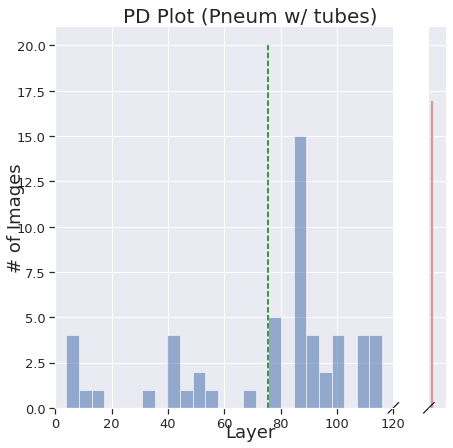

In [148]:
plt.figure(figsize=(7,7)) 

baxes = brokenaxes(xlims=((0,120),(100004,100010)), hspace=.05)
baxes.set_title(f'PD Plot (Pneum w/ tubes)',fontsize=20)
baxes.set_ylabel('# of Images',fontsize=18)
baxes.set_xlabel('Layer',fontsize=18)  
baxes.tick_params(axis='x', which='major', labelsize=13)
baxes.tick_params(axis='y', which='major', labelsize=13)

# baxes.set_ylim((0,80))
baxes.hist(batch_info['pd'][mask],bins=25,color='b',alpha=0.55)
# baxes.hist(batch_info['pd'][~correct_preds_arr & pos_pd_arr],bins=30,color='b',alpha=0.55)
batch_info['pd'][~pos_pd_arr] = 100005
baxes.hist(batch_info['pd'][~pos_pd_arr],bins=1,color='r',alpha=0.55)
baxes.vlines(pd_mean,0,20,color='green',linestyle='dashed')

Text(0.5, 1.0, 'PVI Plot (Pneum w/ tubes)')

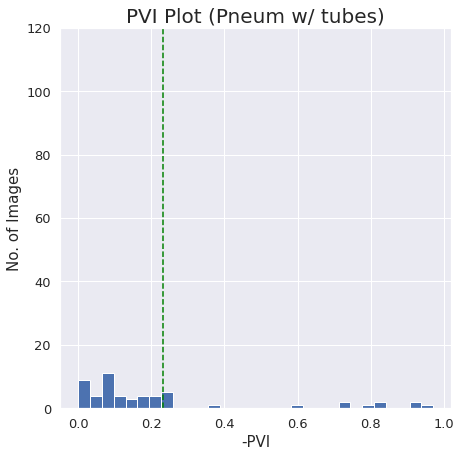

In [149]:
plt.figure(figsize=(7,7)) 
ylim = 120
plt.hist(-batch_info['pvi'][mask],bins=30)
# plt.axvline(x=neg_pvi_mean,marker='-')
plt.vlines(neg_pvi_mean,0,ylim,color='green',linestyle='dashed')
plt.ylim(0,ylim)
plt.xlabel('-PVI',fontsize=15)  
plt.ylabel('No. of Images',fontsize=15)  
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('PVI Plot (Pneum w/ tubes)', fontsize=20)

In [127]:
print(pd_mean,neg_pvi_mean)

75.33333333333333 0.23284215723250165


array([0.97, 1.  , 1.  , 0.53, 0.98, 0.94, 0.91, 0.8 , 0.73, 0.94, 1.  ,
       0.91, 0.88, 0.52, 0.99, 0.99, 0.89, 0.65, 1.  , 0.58, 0.99, 1.  ,
       0.8 , 1.  , 0.52, 1.  , 0.79, 0.73, 0.83, 0.97, 0.62, 1.  , 0.99,
       0.91, 0.85, 0.99, 1.  , 0.91, 0.76, 0.96, 1.  , 0.85, 0.81, 0.94,
       0.97, 0.74, 0.95, 1.  , 0.73, 1.  , 0.83, 0.62, 1.  , 0.97, 0.93,
       0.99, 1.  , 0.87, 0.99, 0.93, 0.7 , 1.  , 0.93, 0.89, 1.  , 1.  ,
       0.84, 1.  , 1.  , 1.  , 0.86, 0.85, 1.  , 1.  , 1.  , 1.  , 0.69,
       0.72, 0.99, 0.83])

array([ True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
       False, False,  True,  True,  True,  True, False,  True, False,
        True, False, False,  True,  True, False,  True,  True,  True,
       False, False, False,  True,  True,  True, False, False, False,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False, False, False,  True,  True,  True, False,  True, False,
       False, False,  True,  True,  True,  True, False, False,  True,
       False,  True, False,  True,  True,  True, False,  True,  True,
       False, False, False, False,  True,  True, False,  True, False,
        True, False, False,  True,  True,  True,  True, False, False,
        True,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False, False,  True,  True,  True,  True, False,
        True, False,

# Compute PVI Toy data

In [25]:
'''
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/nih_shortcut_l1_pos_notube_v3.pkl
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/data/nih/pd_analysis/imgsize_128/nih_shortcut/nih_shortcut_l1_pos_tube_v3.pkl
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/batch1/vgg16_kmnist_27437_testPDinfo.pkl
/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/batch1/vgg16_kmnist_patch_48316_testPDinfo.pkl
'''
# plot PDs histogram
with open('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/output/vgg16_kmnist_patch_86506_testPDinfo.pkl', 'rb') as handle:
    batch_info = pickle.load(handle)

In [26]:
batch_info['pd'] = np.array(batch_info['pd'])
batch_info['labels'] = np.array(batch_info['labels'])
batch_info['preds'] = np.array(batch_info['preds'])
batch_info['pred_probs'] = np.array(batch_info['pred_probs'])
batch_info['pvi'] = np.log2(batch_info['pred_probs']+1e-10)

pred_cls = (batch_info['preds']>0.5).astype(int)
correct_preds_arr = (pred_cls==batch_info['labels'])

In [27]:
mask = correct_preds_arr & (batch_info['pd']>=0) & (batch_info['pd']<=17)
pd_mean = np.mean(batch_info['pd'][mask])
neg_pvi_mean = np.mean(-batch_info['pvi'][mask])
print(f'pd_mean={pd_mean}, neg_pvi_mean={neg_pvi_mean}')

pd_mean=1.12, neg_pvi_mean=0.0024905918904872476


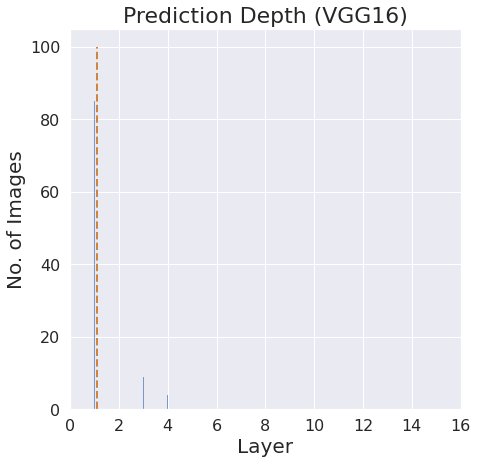

In [28]:
sns.set(style="darkgrid")

plt.figure(figsize=(7,7))
plt.title('Prediction Depth (VGG16)', fontsize=22)
plt.ylabel('No. of Images', fontsize=20)
plt.xlabel('Layer', fontsize=20)
plt.xlim((0,16))
# plt.ylim((0,550))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

pd_mean = np.mean(batch_info['pd'][mask])

sns_hist = sns.histplot(batch_info['pd'],bins=100)
sns_hist.vlines(pd_mean,0,100,color='peru',linestyle='dashed',linewidth=2)

Text(0.5, 1.0, 'PVI Plot (Pneum w/ tubes)')

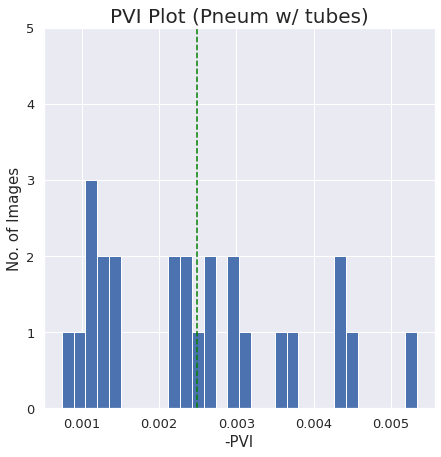

In [30]:
plt.figure(figsize=(7,7)) 
ylim = 5
plt.hist(-batch_info['pvi'][mask],bins=30)
# plt.axvline(x=neg_pvi_mean,marker='-')
plt.vlines(neg_pvi_mean,0,ylim,color='green',linestyle='dashed')
plt.ylim(0,ylim)
plt.xlabel('-PVI',fontsize=15)  
plt.ylabel('No. of Images',fontsize=15)  
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('PVI Plot (Pneum w/ tubes)', fontsize=20)

# Misc

In [ ]:
import pandas as pd
df = pd.read_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/nih/512/nih.csv')


In [ ]:
# df = df[df['test_split']==1]
# df0 = df[df['Pneumothorax']==0].sample(2000)
# df1 = df[df['Pneumothorax']==1].sample(2000)
# df_final = pd.concat([df0,df1]).sample(frac=1)
# df_final.to_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/nih/512/nih_subset.csv',index=False)

In [ ]:
# df = pd.read_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/mimic/512/raw_test.csv')
# df1 = df[df['pneumothorax']==1]
# df0 = df[df['pneumothorax']==0].sample(916)
# pd.concat([df0,df1]).sample(frac=1).to_csv('/xxx/home/xxx/xxx22p/xxx/projects/shortcut_detection_and_mitigation/experiments/medical_expts/mimic/512/mimic_test.csv',index=False)